In [3]:
import glob
import shutil
import json
from pathlib import Path

from collections import Counter

import pandas as pd
import xml.etree.ElementTree as ET

import cv2
import numpy as np
from PIL import Image

# Labelmg to COCO format

Labelmg by default creates files in the **Pascal VOC** format. Most of the latest pipelines are
expecting the labels in COCO format.

1. Pascal VOC format -> coordinates are represented as `(left_top, right_bottom)`
2. Labelmg tool produces Pascal voc format.
3. COCO expects all the file names should be in number format
4. COCO files

In [ ]:
train_dir = "/home/haridas/projects/mystique/data/pic2card_dataset_nov_6/train/"
test_dir = "/home/haridas/projects/mystique/data/pic2card_dataset_nov_6/val/"
template_test = "/home/haridas/projects/mystique/data/train_and_test-2020-Jun-05-coco/templates_test_data_coco/"

In [ ]:
tree = ET.parse(f"{template_test}/1.xml")
root = tree.getroot()
fn_child = root.find("filename")

In [ ]:
fn_child.text = "1.jpg"

In [ ]:
# print(ET.tostring(root).decode('utf8'))

In [ ]:
def renamefn_to_intfn(data_dir, start=1000):
    """
    @param data_dir: Pascal VOC format generated by labelmg.
    @param start: File name start point.
    """
    get_fn = lambda x: ".".join(x.split(".")[:-1])

    pp = Path(data_dir)
    for fn in glob.glob(f"{data_dir}/*.xml"):
        p = Path(fn)
        root = ET.parse(fn).getroot()
        fn_child = root.find("filename")
        path_child = root.find("path")
        img_fn = fn_child.text
        
        if not get_fn(p.name).isdigit():
            bname = ".".join(p.name.split(".")[:-1])
            png = Path(pp / f"{img_fn}")
            assert png.exists()
            
            imgfn_split = img_fn.split(".")
            img, img_ext = ".".join(imgfn_split[:-1]), imgfn_split[-1]
            
            p.rename(pp / f"{start}.xml")
            png.rename(pp / f"{start}.{img_ext}")
            
            # Update the filename reference in new xml 
            fn_child.text = f"{start}.{img_ext}"
            path_child.text = f"{pp/str(start)}.{img_ext}"
            
            with open(pp/f"{start}.xml", 'w') as f:
                f.write(ET.tostring(root).decode("utf8"))
            
            start += 1

In [ ]:
renamefn_to_intfn(template_test)

In [165]:
root = ET.parse("/home/haridas/projects/mystique/data/train/1.xml")

In [177]:
# root.findall("object")

# Image Data Analysis

Ensure the Dataset has correct labels and category ID mapping across train/val/test datasets.

In [ ]:
# xml_dir = "/home/haridas/projects/mystique/data/pic2card_dataset_03_mar_2021/train"

In [65]:
train_ann_file = "/home/haridas/projects/mystique/data/pic2card_dataset_03_mar_2021/train_coco.json"
val_ann_file = "/home/haridas/projects/mystique/data/pic2card_dataset_03_mar_2021/val_coco.json"
test_ann_file = "/home/haridas/projects/mystique/data/pic2card_dataset_03_mar_2021/test_coco.json"

In [227]:
train_ann_file_new = "/mnt1/haridas/projects/AdaptiveCards/source/pic2card/train_coco.json"
val_ann_file_new = "/mnt1/haridas/projects/AdaptiveCards/source/pic2card/val_coco.json"
test_ann_file_new = "/mnt1/haridas/projects/AdaptiveCards/source/pic2card/test_coco.json"

In [236]:
def bbox_aspect_ratio(bbox):
    "coco bbox convention"
    x1, y1, width, height = bbox
    return width / height


def get_bbox_annotations(ann_file):
    ann = json.loads(open(ann_file).read())
    bbox_areas = pd.DataFrame.from_records([i for i in ann['annotations']])
    bbox_areas['aspect_ratio'] = bbox_areas.bbox.apply(bbox_aspect_ratio)
    return bbox_areas

def image_meta(ann_file):
    ann = json.loads(open(ann_file).read())
    image_df = pd.DataFrame.from_records([i for i in ann['images']])
    return image_df

def verify_xml_vs_coco(voc_dir, coco_json_file):
    """
    Double check each annotations are being encoded
    correctly to the coco_json format.
    """
    ann_df = get_bbox_annotations(coco_json_file)
    ann_count_dict = dict(ann_df.groupby("image_id").count()['area'].items()) 
    #return ann_count_dict, ann_df
    for xfile in glob.glob(f"{voc_dir}/*.xml"):
        root = ET.parse(xfile)
        obj_count = len(root.findall("object"))
        img_id = xfile.split("/")[-1].split('.')[0]
        assert(obj_count == ann_count_dict[int(img_id)])
        #raise Exception("Annotation mismatch between coco object and voc")
    print(f"All bbox count matched for: {voc_dir} and {coco_json_file}")
    
train_annotations = get_bbox_annotations(train_ann_file)
train_image_df = image_meta(train_ann_file)
test_image_df = image_meta(test_ann_file)
val_image_df = image_meta(val_ann_file)

In [237]:
verify_xml_vs_coco("/home/haridas/projects/mystique/data/pic2card_dataset_03_mar_2021/test", test_ann_file_new)

All bbox count matched for: /home/haridas/projects/mystique/data/pic2card_dataset_03_mar_2021/test and /mnt1/haridas/projects/AdaptiveCards/source/pic2card/test_coco.json


In [83]:
# train_image_df.describe(percentiles=np.arange(0, 1, 0.1))
train_dict = json.loads(open(train_ann_file).read())
val_dict = json.loads(open(val_ann_file).read())
test_dict = json.loads(open(test_ann_file).read())

In [159]:
# train_annotations1 = get_bbox_annotations(train_ann_file_new)
# train_image_df1 = image_meta(train_ann_file_new)
# train_dict1 = json.loads(open(train_ann_file_new).read())

In [158]:
# test_image_df1.id.value_counts()

In [175]:
# train_dict1.keys()
# dict(train_annotations1.groupby("image_id").count()['area'].items())

In [176]:
# train_dict1['annotations']
# 546/422

In [127]:
# train_annotations1[(train_annotations1.aspect_ratio > 1.29) & (train_annotations1.aspect_ratio < 1.3)]

In [164]:
# sorted(train_dict1["images"], key=lambda x: x['id'])

In [ ]:
bbox_area[bbox_area.area == 458216]

In [ ]:
np.arange(0, 1, 0.1)

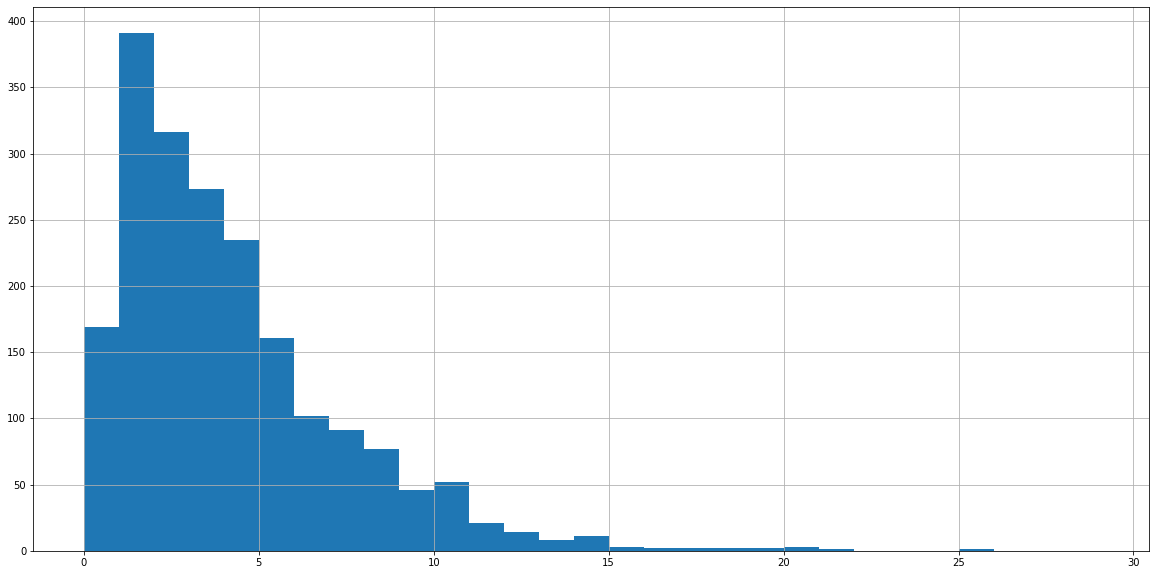

In [10]:
bbox_area.aspect_ratio.hist(bins=np.arange(0, 30, 1), xlabelsize=10, figsize=(20,10))
# bbox_area.aspect_ratio.plot(kind="pie", xticks=[0, 0.5, 0.1, 1.5], xlim=(0, 1.5))

In [33]:
bbox_area.aspect_ratio.describe(percentiles=np.arange(0, 1, 0.05))[1:-1]

mean     4.206018
std      3.295294
min      0.406250
0%       0.406250
5%       0.945455
10%      1.006929
15%      1.094879
20%      1.350000
25%      1.714286
30%      2.094048
35%      2.412186
40%      2.719500
45%      3.066237
50%      3.374233
55%      3.736199
60%      4.137143
65%      4.595285
70%      5.021503
75%      5.620690
80%      6.335741
85%      7.347826
90%      8.662500
95%     10.331183
Name: aspect_ratio, dtype: float64

In [34]:
# area_bbox.hist(column="area", bins=1000)
sorted(bbox_area[bbox_area.aspect_ratio >= 10].image_id.unique())

[1,
 2,
 5,
 6,
 8,
 12,
 13,
 16,
 17,
 20,
 21,
 23,
 24,
 26,
 31,
 32,
 36,
 42,
 43,
 45,
 46,
 50,
 53,
 57,
 58,
 63,
 66,
 67,
 71,
 73,
 78,
 80,
 81,
 82,
 85,
 87,
 91,
 92,
 93,
 101,
 106,
 108,
 1000,
 1002,
 1003,
 1004,
 1008,
 1009,
 10004,
 10008,
 10012,
 10014,
 20001,
 20004,
 20005,
 20015,
 20018,
 20019,
 20025,
 20031,
 20032,
 20034,
 20037,
 20038,
 20039,
 20040,
 20041]

In [50]:
## BBOX Count distribution analysis
bbox_count_dist = bbox_area.groupby("image_id").count()["area"]
bbox_count_dist.describe(np.arange(0, 1, 0.05))[1:-1]

mean    12.806452
std     10.782439
min      2.000000
0%       2.000000
5%       3.000000
10%      4.000000
15%      4.000000
20%      5.000000
25%      6.000000
30%      6.000000
35%      7.000000
40%      8.000000
45%      9.000000
50%     10.000000
55%     11.000000
60%     13.000000
65%     14.000000
70%     15.000000
75%     17.000000
80%     19.000000
85%     21.000000
90%     25.000000
95%     29.300000
Name: area, dtype: float64

In [57]:
# Image with more than n bboxes. Seems overkill for an card based detection.
bbox_count_dist[bbox_count_dist > 20]

image_id
4        28
8        25
12       32
13       26
16       24
17       37
29       30
32       21
37       21
45       25
46       25
47       24
48       29
49       21
57       22
58       41
78       26
79       55
94       27
10004    35
10005    22
10008    89
10009    29
10017    33
10018    24
Name: area, dtype: int64

In [59]:
bbox_area[bbox_area.image_id == 4]

,area,iscrowd,image_id,bbox,category_id,id,ignore,segmentation,aspect_ratio
1149,3051,0,4,"[412, 22, 113, 27]",1,1150,0,[],4.185185
1150,4278,0,4,"[389, 51, 138, 31]",1,1151,0,[],4.451613
1151,2990,0,4,"[24, 109, 115, 26]",1,1152,0,[],4.423077
1152,1104,0,4,"[475, 111, 46, 24]",1,1153,0,[],1.916667
1153,2650,0,4,"[23, 140, 106, 25]",1,1154,0,[],4.240000
1154,4500,0,4,"[23, 164, 150, 30]",1,1155,0,[],5.000000
1155,3219,0,4,"[21, 196, 111, 29]",1,1156,0,[],3.827586
1156,880,0,4,"[484, 141, 40, 22]",1,1157,0,[],1.818182
1157,874,0,4,"[484, 168, 38, 23]",1,1158,0,[],1.652174
1158,1134,0,4,"[484, 195, 42, 27]",1,1159,0,[],1.555556


# Data Category analysis

In [58]:
def check_category_id(ann_file):
    ann = json.loads(open(ann_file).read())
    cat_map = {i["id"] : i["name"] for i in ann["categories"]}
    print(f"Number of images: {len(set([i['file_name'] for i in ann['images']]))}")
    print({(k, cat_map[k]): v for k, v in Counter([i["category_id"] for i in ann["annotations"]]).items()})
    return ann["categories"]

check_category_id(train_ann_file)

Number of images: 155
{(3, 'checkbox'): 89, (2, 'radiobutton'): 152, (1, 'textbox'): 1225, (4, 'actionset'): 115, (5, 'image'): 404}


[{'supercategory': 'none', 'id': 1, 'name': 'textbox'},
 {'supercategory': 'none', 'id': 2, 'name': 'radiobutton'},
 {'supercategory': 'none', 'id': 3, 'name': 'checkbox'},
 {'supercategory': 'none', 'id': 4, 'name': 'actionset'},
 {'supercategory': 'none', 'id': 5, 'name': 'image'}]

In [ ]:
check_category_id(val_ann_file)

In [ ]:
check_category_id(test_ann_file)

In [ ]:
Counter([i["category_id"] for i in ann["annotations"]])

# Label statistics

In [ ]:
train_df = pd.read_csv("/home/haridas/projects/mystique/data/train_and_test-2020-Jun-05-coco/train_label.csv")

In [ ]:
train_df.groupby("filename").count().describe()

## Morph font weight analysis

In [ ]:
image = Image.open("/tmp/pic2card.png")

In [ ]:
bbox_coord = (27.74326380342245, 58.549769282341, 284.94907945394516, 86.0945338010788)

In [ ]:
cropped_img = image.crop(bbox_coord)

In [ ]:
cropped_img

In [ ]:
c_img = np.asarray(cropped_img)

In [ ]:
gray = cv2.cvtColor(c_img, cv2.COLOR_BGR2GRAY)

In [ ]:
Image.fromarray(gray)

In [ ]:
_, bin_img = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)

In [ ]:
Image.fromarray(bin_img)

In [ ]:
area_img = np.count_nonzero(bin_img)
area_img

In [ ]:
skel_img = np.zeros(bin_img.shape, np.uint8)

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))

In [ ]:
Image.fromarray(bin_img)

In [ ]:
morph_open = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, (3, 3))

In [ ]:
Image.fromarray(morph_open)

In [ ]:
tmp_img =cv2.subtract(bin_img, morph_open)

In [ ]:
Image.fromarray(tmp_img)

In [ ]:
eroded = cv2.erode(bin_img, kernel)

In [ ]:
Image.fromarray(eroded)

In [ ]:
Image.fromarray(skel_img)

In [ ]:
skel_img = cv2.bitwise_or(skel_img, tmp_img)

In [ ]:
Image.fromarray(skel_img)

In [ ]:
def get_weight(image: Image, coords) -> str:
        """
        Extract the weight of the each words by
        skeletization applying morph operations on
        the input image
        @param image : input PIL image
        @param coords: list of coordinated from which
                       text and height should be extracted
        @return: weight
        """
        cropped_image = image.crop(coords)
        c_img = np.asarray(cropped_image)
        """
        if(image_height/image_width) < 1:
            y_scale = round((800/image_width), 2)
            x_scale = round((500/image_height), 2)
            c_img = cv2.resize(c_img, (0, 0), fx=x_scale, fy=y_scale)
        """
        gray = cv2.cvtColor(c_img, cv2.COLOR_BGR2GRAY)
        # Converting input image to binary format
        _, img = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)
        area_of_img = np.count_nonzero(img)
        # creating an empty skeleton
        skel = np.zeros(img.shape, np.uint8)
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
        # Loop until erosion leads to thinning text in image to singular pixel
        images = []
        images.append(Image.fromarray(img))
        while True:
            morph_open = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
            temp = cv2.subtract(img, morph_open)
            eroded = cv2.erode(img, kernel)
            skel = cv2.bitwise_or(skel, temp)
            img = eroded.copy()
            
            images.append(Image.fromarray(skel))
            # if no white pixels left the image has been completely eroded
            if cv2.countNonZero(img) == 0:
                break
        # length of the lines in text
        area_of_skel = np.sum(skel)/255
        # width of line = area of the line / length of the line
        thickness = round(area_of_img/area_of_skel, 2)
        return thickness, images

In [ ]:
think, inter_images = get_weight(image, bbox_coord)

In [ ]:
inter_images[0]

In [ ]:
np.count_nonzero()

In [ ]:
np.asarray(inter_images[-1])

In [ ]:
np.count_nonzero(bin_img)

In [ ]:
bin_img.shape

In [ ]:
proc_img = np.asarray(inter_images[-1])

In [ ]:
Image.fromarray(proc_img)

In [ ]:
proc_img[proc_img.nonzero()]